In [75]:
! pip install tabulate optuna

# Importing necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import RFE
import itertools
import time
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.model_selection import cross_val_score
from tabulate import tabulate
import optuna
from joblib import dump
from joblib import load





#### Data Loading and Initial Exploration


In [76]:
# load Train data
train_data = pd.read_csv('../Data/Final_skin_cancer.csv')

# train_data.drop('drink', axis=1, inplace=True)
# # save data


In [77]:
# train_data.drink.value_counts()

In [78]:
# General information and statistics about the train data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1705 entries, 0 to 1704
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   smoke                1705 non-null   bool 
 1   drink                1705 non-null   bool 
 2   age                  1705 non-null   int64
 3   pesticide            1705 non-null   bool 
 4   gender               1705 non-null   int64
 5   skin_cancer_history  1705 non-null   bool 
 6   cancer_history       1705 non-null   bool 
 7   has_piped_water      1705 non-null   bool 
 8   has_sewage_system    1705 non-null   bool 
 9   diagnostic           1705 non-null   int64
dtypes: bool(7), int64(3)
memory usage: 51.7 KB


#### Feature Selection and Normalization

In [79]:
# Splitting data into features and target
X_train = train_data.drop(['diagnostic'], axis=1)
Y_train = train_data['diagnostic']

In [80]:
# What is happening in this code
# Random Forest Classifier is used to rank the importance of features
# RFE is used to select the most important features
# we will use 5 features in our model
# we will use the selected features to train our model
# we will use the selected features to test our model

# Feature selection using Random Forest Classifier
rfc = DecisionTreeClassifier()  # Using Decision Tree for feature selection
rfe = RFE(rfc, n_features_to_select=7)
rfe = rfe.fit(X_train, Y_train)

# Selecting important features
feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), X_train.columns)]
selected_features = [v for i, v in feature_map if i==True]
selected_features

['drink',
 'age',
 'pesticide',
 'gender',
 'skin_cancer_history',
 'cancer_history',
 'has_sewage_system']

In [81]:
# Train data with selected features
X_train = X_train[selected_features]

In [82]:

# Splitting the dataset for training and testing
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, train_size=0.70, random_state=42)

#### Decision Tree Model Training and Tuning

In [83]:

# Training a basic Decision Tree Classifier
# Time to train the model
clfd = DecisionTreeClassifier(criterion ="entropy", max_depth = 4)
start_time = time.time()
clfd.fit(x_train, y_train.values.ravel())
end_time = time.time()
print("Training time: ", end_time-start_time)

Training time:  0.001550912857055664


In [84]:
# Time taken to test the model
start_time = time.time()
y_test_pred = clfd.predict(x_train)
end_time = time.time()
print("Testing time: ", end_time-start_time)

Testing time:  0.0007429122924804688


In [85]:

# Hyperparameter Tuning for Decision Tree using Optuna
def objective(trial):
    dt_max_depth = trial.suggest_int('dt_max_depth', 2, 32, log=False)
    dt_max_features = trial.suggest_int('dt_max_features', 2, 5, log=False)
    classifier_obj = DecisionTreeClassifier(max_features=dt_max_features, max_depth=dt_max_depth)
    classifier_obj.fit(x_train, y_train)
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy


In [86]:
# start the optimization process
study_dt = optuna.create_study(direction='maximize')
study_dt.optimize(objective, n_trials=30)
print(study_dt.best_trial)

[I 2024-02-28 13:45:00,011] A new study created in memory with name: no-name-456b2edb-6502-47f6-b105-616aa53f061e
[I 2024-02-28 13:45:00,015] Trial 0 finished with value: 0.943359375 and parameters: {'dt_max_depth': 16, 'dt_max_features': 4}. Best is trial 0 with value: 0.943359375.
[I 2024-02-28 13:45:00,016] Trial 1 finished with value: 0.87109375 and parameters: {'dt_max_depth': 5, 'dt_max_features': 2}. Best is trial 0 with value: 0.943359375.
[I 2024-02-28 13:45:00,019] Trial 2 finished with value: 0.94140625 and parameters: {'dt_max_depth': 6, 'dt_max_features': 5}. Best is trial 0 with value: 0.943359375.
[I 2024-02-28 13:45:00,022] Trial 3 finished with value: 0.9375 and parameters: {'dt_max_depth': 31, 'dt_max_features': 4}. Best is trial 0 with value: 0.943359375.
[I 2024-02-28 13:45:00,024] Trial 4 finished with value: 0.947265625 and parameters: {'dt_max_depth': 22, 'dt_max_features': 4}. Best is trial 4 with value: 0.947265625.
[I 2024-02-28 13:45:00,026] Trial 5 finished 

FrozenTrial(number=24, state=1, values=[0.951171875], datetime_start=datetime.datetime(2024, 2, 28, 13, 45, 0, 127481), datetime_complete=datetime.datetime(2024, 2, 28, 13, 45, 0, 133304), params={'dt_max_depth': 28, 'dt_max_features': 3}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'dt_max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'dt_max_features': IntDistribution(high=5, log=False, low=2, step=1)}, trial_id=24, value=None)


In [87]:

# Training the Decision Tree model with the best parameters
dt = DecisionTreeClassifier(max_features=study_dt.best_trial.params['dt_max_features'], max_depth=study_dt.best_trial.params['dt_max_depth'])
dt.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=28, max_features=3)

#### Model Evaluation

In [88]:
# Model Performance Metrics
dt_train, dt_test = dt.score(x_train, y_train), dt.score(x_test, y_test)
print(f"Train Score: {dt_train}")
print(f"Test Score: {dt_test}")


Train Score: 0.9857502095557418
Test Score: 0.935546875


In [89]:

# Cross-Validation why we use cross-validation?
# Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample.
# The goal of cross-validation is to test the model’s ability to predict new data that was not used in estimating it
# we will use cross-validation to evaluate the performance of our model
# we will use 10 folds for cross-validation
# we will use the accuracy metric to evaluate the performance of our model

scores = cross_val_score(dt, x_train, y_train, cv=10, scoring='accuracy')
print(f"Cross-Validation Accuracy: {np.mean(scores)}")

Cross-Validation Accuracy: 0.9371148459383754


In [90]:
# Confusion Matrix and Classification Report why we use these metrics?
# Confusion matrix is used to evaluate the performance of a classification model
# Classification report is used to measure the quality of predictions from a classification algorithm
y_pred = dt.predict(x_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

[[ 43  22]
 [ 11 436]]
              precision    recall  f1-score   support

           0       0.80      0.66      0.72        65
           1       0.95      0.98      0.96       447

    accuracy                           0.94       512
   macro avg       0.87      0.82      0.84       512
weighted avg       0.93      0.94      0.93       512

F1 Score: 0.96353591160221


#### Summary Table

In [91]:

# Creating a summary table of model performance
data = [["Decision Tree", dt_train, dt_test, np.mean(scores), f1]]
col_names = ["Model", "Train Score", "Test Score", "CV Accuracy", "F1 Score"]
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

╒═══════════════╤═══════════════╤══════════════╤═══════════════╤════════════╕
│ Model         │   Train Score │   Test Score │   CV Accuracy │   F1 Score │
╞═══════════════╪═══════════════╪══════════════╪═══════════════╪════════════╡
│ Decision Tree │       0.98575 │     0.935547 │      0.937115 │   0.963536 │
╘═══════════════╧═══════════════╧══════════════╧═══════════════╧════════════╛


#### Saving the model

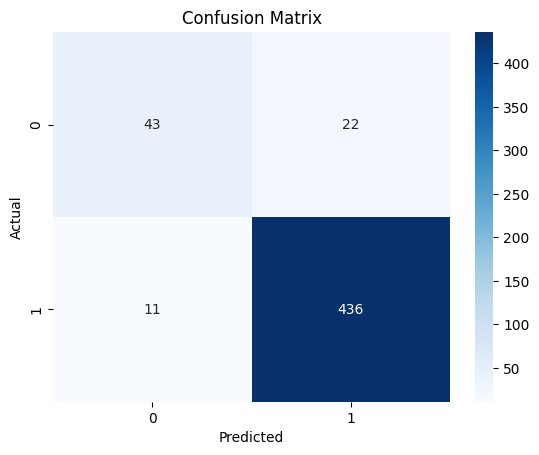

In [92]:
# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [93]:
# # Save the model to a file
# model_filename = 'decision_tree_model.joblib'
# dump(dt, model_filename)
# print(f"Model saved to {model_filename}")

#### Load the model

In [94]:
# # Load the model from the file
# loaded_model = load(model_filename)
# print("Model loaded successfully")